In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/archive8.zip'
extract_path = '/content'  # Extract to /content so the dataset is easily accessible

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extracted files
print("Extracted Files:", os.listdir(extract_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted Files: ['.config', 'archive8', '__MACOSX', 'drive', 'sample_data']


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Define dataset path
dataset_path = "/content/archive8/images/images"

# Data Generator for loading and preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Load dataset from directories
data = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # Resize images to 224x224 (VGG16 input size)
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    shuffle=True
)

# Extract data and labels
images, labels = [], []
for i in range(len(data)):
    x, y = data[i]
    images.append(x)
    labels.append(y)
    if len(images) * data.batch_size >= data.n:  # Stop when all data is loaded
        break

images = np.vstack(images)  # Combine into a single numpy array
labels = np.vstack(labels)


Found 900 images belonging to 10 classes.


In [ ]:
# Load the pretrained VGG16 model (excluding the top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define the feature extractor model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features
features = feature_extractor.predict(images)
features = features.reshape(features.shape[0], -1)  # Flatten the features

# Convert one-hot encoded labels to class indices
labels = np.argmax(labels, axis=1)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 542s 19s/step


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [ ]:
# Initialize and train the Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)




RandomForestClassifier(random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       0.93      1.00      0.96        25
           2       0.91      1.00      0.95        21
           3       0.88      1.00      0.93        14
           4       0.79      0.69      0.73        16
           5       0.79      0.83      0.81        23
           6       0.71      0.75      0.73        16
           7       0.94      0.74      0.83        23
           8       0.94      0.80      0.86        20
           9       0.75      0.60      0.67        15

    accuracy                           0.84       180
   macro avg       0.82      0.84      0.82       180
weighted avg       0.85      0.84      0.84       180



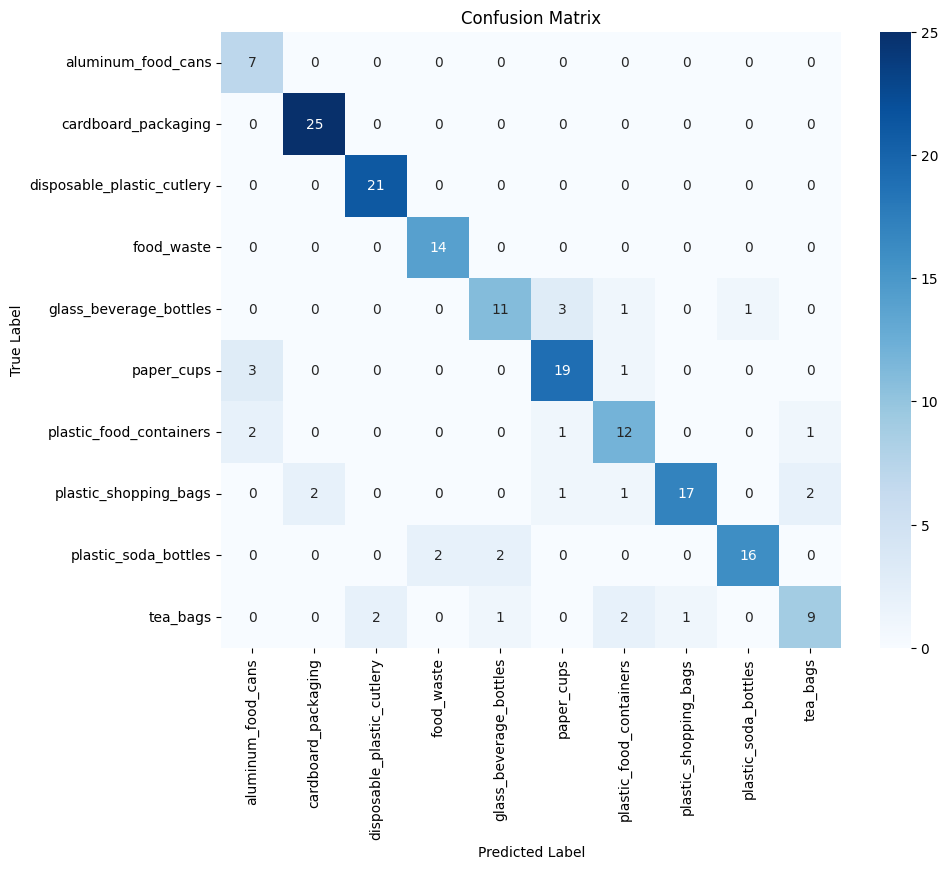

In [ ]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.class_indices.keys(), yticklabels=data.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

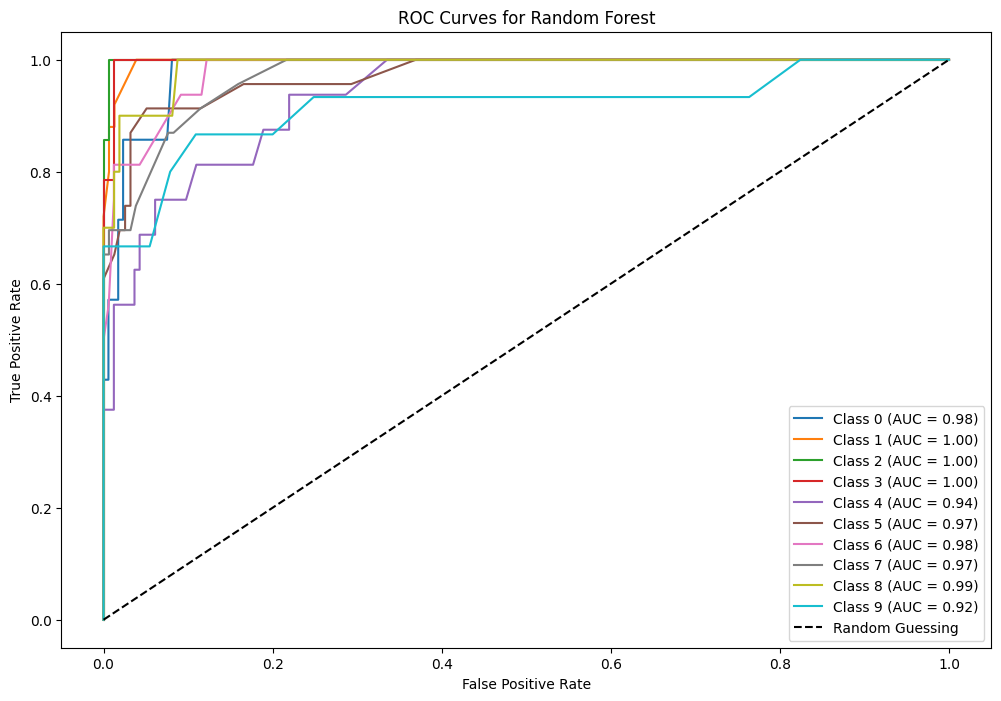

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels for ROC curve (needed for multi-class classification)
y_test_binarized = label_binarize(y_test, classes=np.unique(labels))

# Get predicted probabilities from Random Forest
y_pred_proba = rf_model.predict_proba(X_test)

# Plot ROC curves for each class
plt.figure(figsize=(12, 8))
for i in range(y_test_binarized.shape[1]):  # Iterate through each class
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Plot diagonal for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Random Forest')
plt.legend()
plt.show()
